In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
from statsmodels.tsa.seasonal import STL

In [3]:
#df_id = pd.read_csv("data/train_identity.csv")
df_trans = pd.read_csv("data/train_transaction.csv")

In [4]:
def entropyValues(values):
    if len(values) >= 3:
        return np.nan_to_num(entropy(values, base=2), nan=0, posinf=0, neginf=0)
    else:
        return -1
def stdValue(vlr):
    if len(vlr) > 1:
        max = np.max(vlr)
        avg = np.mean(vlr)

        return np.nan_to_num(np.divide(avg,max), nan=1, posinf=1, neginf=1)
    else:
        return 1
def correlation(vlr):
  if stats.uniform.fit(vlr)[1] == 0:
    return 0

  if len(vlr) > 1:
    #interval = list(range(0,len(vlr)))
    interval = stats.powerlaw.rvs(2,size=(len(vlr)))
    return stats.pearsonr(vlr, interval)[0]
  else:
    return 0

In [5]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    # memory error
    #for name in summary['Name'].value_counts().index:
    #    summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [6]:
## Reducing memory
df_trans = reduce_mem_usage(df_trans)
#df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)


# EDA

## Knowing partial data

In [1]:
resumetable(df_trans)[:100]

NameError: name 'resumetable' is not defined

### Mostly problems of fraud detection is unbalanced

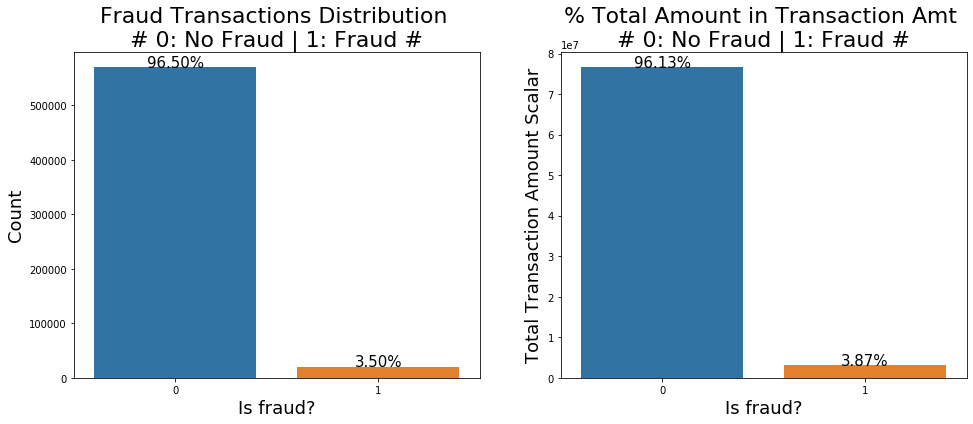

In [10]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

### Another problem in credit card operations is a outlier behavior

In [11]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


### Therefore, the elimination of outliers can be a risk, because sometimes the fraudulent behavior can be present in anomalies.
 The objective of this project is to implement a time series approach based on the repetition of credit card use in window time. The second goal is to introduce this data in unsupervised machine learning techniques, and the third is to join with a supervised machine learning technique through a voting classifier.

In [12]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

In [13]:
df_trans.index = df_trans["Date"]

In [14]:
df_trans['ds'] = df_trans["Date"].dt.strftime("%Y-%m-%d %H:00:00")

In [15]:
df_trans.index = df_trans[['ds', 'card1']]

In [16]:
fraudsTwoOrMore = df_trans.loc[df_trans.groupby(['ds', 'card1'])['TransactionID'].count() > 1]['isFraud'].value_counts()[1]
fraudsOnlyOne = df_trans.loc[df_trans.groupby(['ds', 'card1'])['TransactionID'].count() == 1]['isFraud'].value_counts()[1]
totalFrauds = df_trans['isFraud'].value_counts()[1]

In [17]:
print("Two or more frauds with same credit card: {}%".format(round((fraudsTwoOrMore / totalFrauds) * 100)))
print("Only one fraud with credit card: {}%".format(round((fraudsOnlyOne / totalFrauds) * 100)))

Two or more frauds with same credit card: 58%
Only one fraud with credit card: 42%


In [18]:
## STL

In [19]:
def residualTrend(df):
    qtde = df.TransactionID.copy()
    qtde.index = df.ds
    period = 24
    seasonal = period + ((period % 2) == 0)

    low_pass_jump = seasonal_jump = int(0.15 * (period + 1))
    trend_jump = int(0.15 * 1.5 * (period + 1))

    mod = STL(qtde, period=period, seasonal=seasonal, seasonal_jump=seasonal_jump,
          trend_jump=trend_jump, low_pass_jump=low_pass_jump, robust=True)

    res = mod.fit()

    return res

In [20]:
df_count = df_trans.groupby(['ds', 'card1'])['TransactionID'].count().reset_index()
df_count['rid'] = df_count.index

In [21]:
residual = residualTrend(pd.DataFrame(df_count[['ds', 'TransactionID']]))

In [22]:
df_count['resid'] = residual.resid.values

In [23]:
df_count.index = df_count[['ds', 'card1']]

In [24]:
df_trans['y'] = df_count['TransactionID']
df_trans['resid'] = df_count['resid']
df_trans['rid'] = df_count['rid']

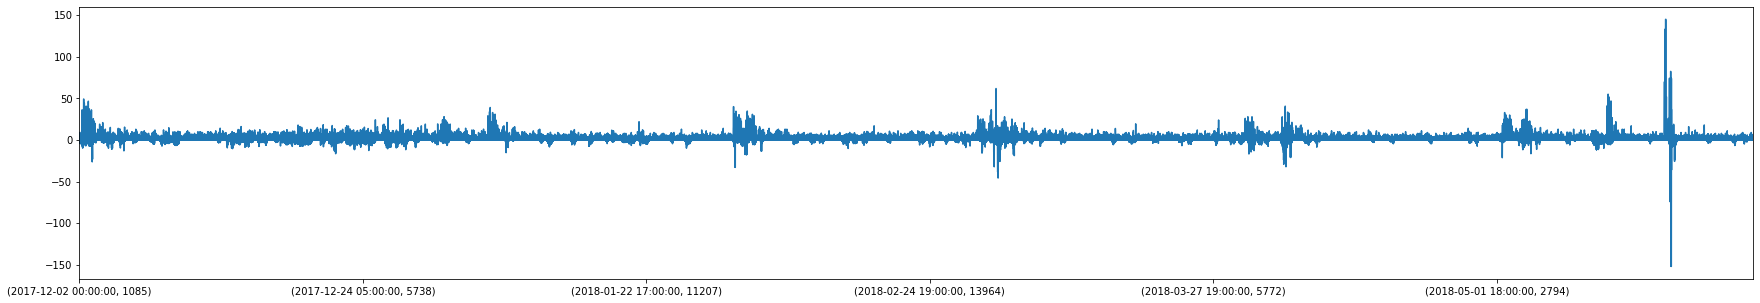

In [25]:
df_trans['resid'].sort_index().plot(figsize=(30,5))
plt.show()

In [26]:
df_trans['resid'].describe()

count    5.905400e+05
mean     1.242414e+00
std      4.615752e+00
min     -1.520143e+02
25%     -2.220446e-16
50%      4.502491e-04
75%      1.208268e+00
max      1.450000e+02
Name: resid, dtype: float64

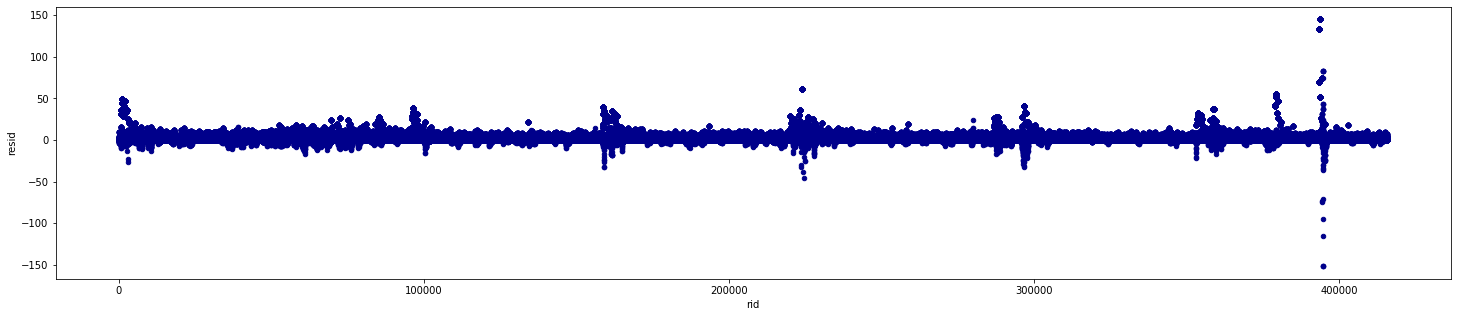

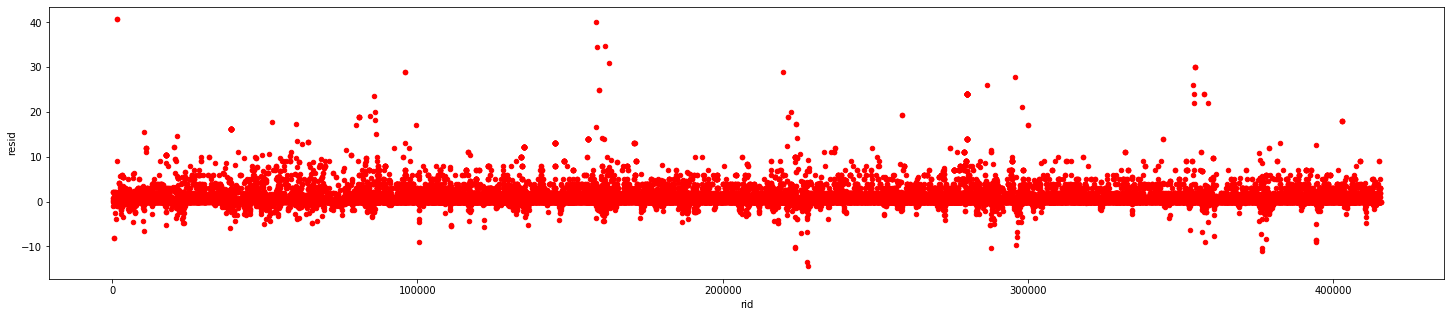

In [27]:
df_trans[df_trans['isFraud'] == False].sort_index().plot(figsize=(25,5), kind='scatter', x='rid', y='resid', c='DarkBlue')
df_trans[df_trans['isFraud'] == True].sort_index().plot(figsize=(25,5), kind='scatter', x='rid', y='resid', c='Red')
plt.show()

In [28]:
df_trans_grouped = df_trans.groupby(['ds', 'card1']).agg(entropy=pd.NamedAgg(column='TransactionAmt', aggfunc=entropyValues), 
                                                          vlrstd=pd.NamedAgg(column='TransactionAmt', aggfunc=stdValue),
                                                         correlation=pd.NamedAgg(column='TransactionAmt', aggfunc=correlation)
                                                          )

In [29]:
df_trans['entropy'] = df_trans_grouped['entropy']
df_trans['vlrstd']  = df_trans_grouped['vlrstd']
df_trans['correlation']  = df_trans_grouped['correlation']

### Some cases of fraud with high entropy and a high number of attempts in the time window

In [30]:
trsh = 1

resid = go.Scatter(
    name = "Resid",
    x = df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].ds.values,
    y = df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].y.values,
    mode='markers',
    marker={
                        'size': df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].resid,
            'color': df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].entropy.values,
            'colorscale': 'Viridis', # one of plotly colorscales
        'showscale': True}
    #y = resume.iloc[resume.index.get_level_values('week_day') == wd]['hour_mean_perc'].values
)

entropia = go.Bar(
    name = 'Entropia',
    x = df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].ds.values,
    y = df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].entropy.values,
)

bar = go.Bar(
    name = 'Qtde',
    x = df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].ds.values,
    y = df_trans[(df_trans['resid'] > trsh) & (df_trans['isFraud'] == True)].y.values,
)


layout = go.Layout(template='plotly_dark', xaxis_tickangle=-45,  bargap=0.15, title="Frauds with high entropy and a high number of attempts in the time window",)

#data = [trace, trend, media, SGD, bar]
data = [resid]
fig = go.Figure(data=data, layout=layout)

In [31]:
py.offline.plot(fig, filename='resid.html') 

'resid.html'

In [32]:
## Including more attributes

In [33]:
c_family = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

In [585]:
selected_vars = ['resid', 'entropy', 'y', 'vlrstd', 'isFraud', 'rid', 'correlation', 'card2',  'card3', 'card5' ]

In [586]:
selected_vars = selected_vars + c_family

In [587]:
x_train, x_test = train_test_split(df_trans[selected_vars], test_size = .30, random_state=1)

In [588]:
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

## Unsupervised Approuch

### Isolation Forest

In [589]:
from sklearn.ensemble import IsolationForest

In [590]:
inliers = df_trans[selected_vars][df_trans.isFraud == False]
inliers = inliers.drop(['isFraud', 'rid'], axis=1).fillna(0)

In [591]:
outliers = df_trans[selected_vars][df_trans.isFraud == True]
outliers = outliers.drop(['isFraud', 'rid'], axis=1).fillna(0)

In [592]:
inliers_train, inliers_test = train_test_split(inliers, test_size=0.30, random_state=42)

In [593]:
model = IsolationForest(n_estimators=100, n_jobs=2,  contamination='auto')
model.fit(inliers_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=2, random_state=None, verbose=0, warm_start=False)

In [594]:
inlier_pred_test = model.predict(inliers_test)
outlier_pred = model.predict(outliers)

In [595]:
print("Accuracy in Detecting Legit Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting Fraud Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting Legit Cases: 0.933015137689806
Accuracy in Detecting Fraud Cases: 0.22378163867782994


### K-Means

In [596]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.base import BaseEstimator, ClassifierMixin
class Kmeans_Classifier(BaseEstimator, ClassifierMixin):
  def __init__(self, n_clusters=2, n_init=15, tol=1e-4, algorithm='elkan',
                random_state=1):
    ## TODO pegar params
    #self.kmeans = KMeans(n_clusters=2, n_init=15, tol=1e-4, algorithm='elkan',
                #random_state=1)
    self.chg = 0
    self.kmeans = GaussianMixture(n_components=2, covariance_type='full', max_iter=50, tol=0.00001, random_state=1)

  def fit(self, target, y=None, sample_weight=None):
    self.kmeans.fit(target, sample_weight)
    self.classes_ = [0,1]

  def predict(self, X):
    preds = self.kmeans.predict(X)
    if list(preds).count(0) > list(preds).count(1):
      y_pred = preds == 1
      self.chg = 1
    else:
      y_pred = preds == 0
      self.chg = 0
    return y_pred

  def predict_proba(self, X):
    preds_prob = self.kmeans.predict_proba(X)
    if self.chg == 1:
      return np.column_stack((preds_prob[:,1], preds_prob[:,0]))
    else:
      return np.column_stack((preds_prob[:,0], preds_prob[:,1]))

In [597]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [600]:
selected_vars2 = ['resid', 'entropy', 'y', 'vlrstd',  'card2', 'correlation', 'card3',  'card5']
selected_vars2 = selected_vars2 + c_family

In [601]:
quantil = StandardScaler().fit(x_train[selected_vars2])
x_train_transf = quantil.transform(x_train[selected_vars2])
x_test_transf = quantil.transform(x_test[selected_vars2])

In [602]:
km = Kmeans_Classifier()
km.fit(x_train_transf)
preds = km.predict(x_test_transf)

In [603]:
#preds_prob = km.predict_proba(x_test_transf)

In [604]:
print(metrics.classification_report(x_test.isFraud, preds))
print(metrics.confusion_matrix(x_test.isFraud, preds))
#print(brier_score_loss(y, km.predict_proba(x_train)[:,1]))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93    171015
           1       0.12      0.39      0.18      6147

    accuracy                           0.88    177162
   macro avg       0.55      0.64      0.56    177162
weighted avg       0.95      0.88      0.91    177162

[[152755  18260]
 [  3751   2396]]


### Supervised approach

In [606]:
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB

In [607]:
gnb = BernoulliNB().fit(x_train_transf, x_train.isFraud)

In [608]:
preds = gnb.predict(x_test_transf)
print(metrics.classification_report(x_test.isFraud, preds))
print(metrics.confusion_matrix(x_test.isFraud, preds))
#print(brier_score_loss(y, gnb.predict_proba(x_train)[:,1]))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    171015
           1       0.33      0.19      0.24      6147

    accuracy                           0.96    177162
   macro avg       0.65      0.59      0.61    177162
weighted avg       0.95      0.96      0.95    177162

[[168678   2337]
 [  4992   1155]]


In [609]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [610]:
dt = DecisionTreeClassifier().fit(x_train_transf, x_train.isFraud)

In [611]:
preds = dt.predict(x_test_transf)
print(metrics.classification_report(x_test.isFraud, preds))
print(metrics.confusion_matrix(x_test.isFraud, preds))
#print(brier_score_loss(y, dt.predict_proba(x_train)[:,1]))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    171015
           1       0.58      0.59      0.58      6147

    accuracy                           0.97    177162
   macro avg       0.78      0.79      0.78    177162
weighted avg       0.97      0.97      0.97    177162

[[168367   2648]
 [  2537   3610]]


In [612]:
features_importance = dt.feature_importances_
 
print("Feature ranking:")
for i, data_class in enumerate(x_train[selected_vars2].columns.values):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))

Feature ranking:
1. resid (0.12292695003191244)
2. entropy (0.03281381589982604)
3. y (0.013615891373897817)
4. vlrstd (0.059983269284203035)
5. card2 (0.1168193277130023)
6. correlation (0.03849456479204807)
7. card3 (0.01802086201301782)
8. card5 (0.04462808162450976)
9. C1 (0.13094867395145934)
10. C2 (0.042766963214122426)
11. C3 (0.0008581279088139374)
12. C4 (0.01608868823793763)
13. C5 (0.007358452352493051)
14. C6 (0.032759113765877056)
15. C7 (0.07093056868885357)
16. C8 (0.02616047010024304)
17. C9 (0.027882060521843274)
18. C10 (0.019099154100652816)
19. C11 (0.02674973271608918)
20. C12 (0.01626150622341549)
21. C13 (0.08924177457606133)
22. C14 (0.0455919509097207)


In [613]:
from sklearn.ensemble import VotingClassifier

In [614]:
eclf = VotingClassifier(estimators=[('km', km), ('nb', gnb), ('dt', dt)] ,
                        voting='soft', weights=[1,1,2], n_jobs=3)

In [615]:
eclf.fit(x_train_transf, x_train.isFraud)

/home/luis/Projetos/KaBum/ml_env2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



VotingClassifier(estimators=[('km',
                              Kmeans_Classifier(algorithm=None, n_clusters=None,
                                                n_init=None, random_state=None,
                                                tol=None)),
                             ('nb',
                              BernoulliNB(alpha=1.0, binarize=0.0,
                                          class_prior=None, fit_prior=True)),
                             ('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                    

In [616]:
preds = eclf.predict(x_test_transf)

In [617]:
print(metrics.classification_report(x_test.isFraud, preds))
print(metrics.confusion_matrix(x_test.isFraud, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    171015
           1       0.57      0.59      0.58      6147

    accuracy                           0.97    177162
   macro avg       0.78      0.79      0.78    177162
weighted avg       0.97      0.97      0.97    177162

[[168309   2706]
 [  2512   3635]]


In [618]:
print(metrics.accuracy_score(x_test.isFraud, preds))
print(metrics.cohen_kappa_score(x_test.isFraud, preds))

0.9705467312403337
0.566898061108128


In [619]:
from sklearn.calibration import CalibratedClassifierCV

In [655]:
clf_sigmoid = CalibratedClassifierCV(eclf, cv=15,  method='sigmoid')
clf_sigmoid.fit(x_train_transf, x_train.isFraud)
prob_pos_sigmoid = clf_sigmoid.predict_proba(x_test_transf)[:, 1]

/home/luis/Projetos/KaBum/ml_env2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

/home/luis/Projetos/KaBum/ml_env2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

/home/luis/Projetos/KaBum/ml_env2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

/home/luis/Projetos/KaBum/ml_env2/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would re

/home/luis/Projetos/KaBum/ml_env2/lib/python3.7/site-packages/seaborn/distributions.py:198: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



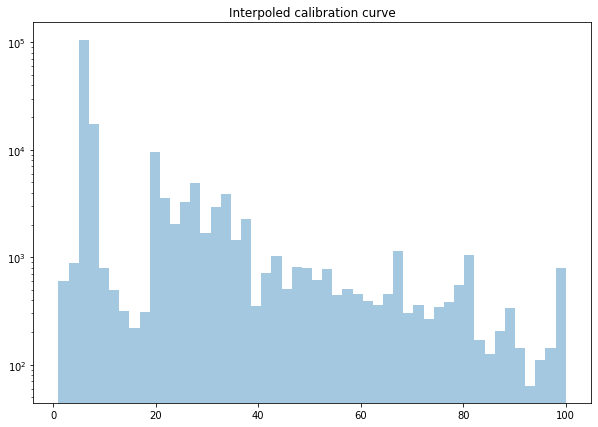

In [656]:
curve_int = np.interp(np.log2(prob_pos_sigmoid) , (np.log2(prob_pos_sigmoid).min(), np.log2(prob_pos_sigmoid) .max()), (1, +100))
f, ax = plt.subplots(figsize=(10, 7))
ax.set( yscale="log")
plt.title("Interpoled calibration curve")
sns.distplot(curve_int, kde=False, ax=ax, label="True")
plt.show()

In [657]:
prob_pos_sigmoid = clf_sigmoid.predict_proba(quantil.transform(df_trans[selected_vars2].fillna(0)))[:, 1]
df_trans['fraud'] = clf_sigmoid.predict(quantil.transform(df_trans[selected_vars2].fillna(0)))
df_trans['score'] = np.interp(np.log2(prob_pos_sigmoid) , (np.log2(prob_pos_sigmoid).min(), np.log2(prob_pos_sigmoid) .max()), (1, +100))

In [658]:
print(metrics.classification_report(df_trans.isFraud, df_trans['fraud']))
print(metrics.confusion_matrix(df_trans.isFraud, df_trans['fraud']))
print(metrics.accuracy_score(df_trans.isFraud, df_trans['fraud']))
print(metrics.cohen_kappa_score(df_trans.isFraud, df_trans['fraud']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    569877
           1       0.98      0.31      0.48     20663

    accuracy                           0.98    590540
   macro avg       0.98      0.66      0.73    590540
weighted avg       0.98      0.98      0.97    590540

[[569758    119]
 [ 14157   6506]]
0.9758255156297626
0.4677976253700604


/home/luis/Projetos/KaBum/ml_env2/lib/python3.7/site-packages/seaborn/distributions.py:198: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



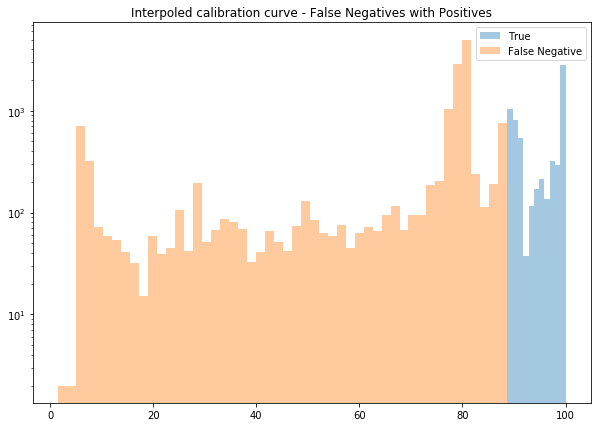

In [659]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set( yscale="log")
plt.title("Interpoled calibration curve - False Negatives with Positives")
sns.distplot(df_trans[(df_trans.isFraud == True) & (df_trans.fraud == True)  & (df_trans.score > 0)].score.values, kde=False, ax=ax, label="True")
sns.distplot(df_trans[(df_trans.isFraud == True) & (df_trans.fraud == False)  & (df_trans.score > 0)].score.values,  kde=False, ax=ax, label="False Negative")
plt.legend(loc='best')
plt.show()

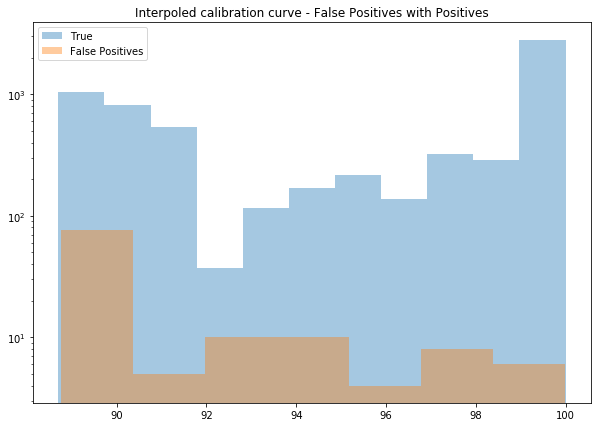

In [660]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set( yscale="log")
plt.title("Interpoled calibration curve - False Positives with Positives")
sns.distplot(df_trans[(df_trans.isFraud == True) & (df_trans.fraud == True)  & (df_trans.score > 0)].score.values, kde=False, ax=ax, label="True")
sns.distplot(df_trans[(df_trans.isFraud == False) & (df_trans.fraud == True)  & (df_trans.score > 0)].score.values,  kde=False, ax=ax, label="False Positives")
plt.legend(loc='best')
plt.show()

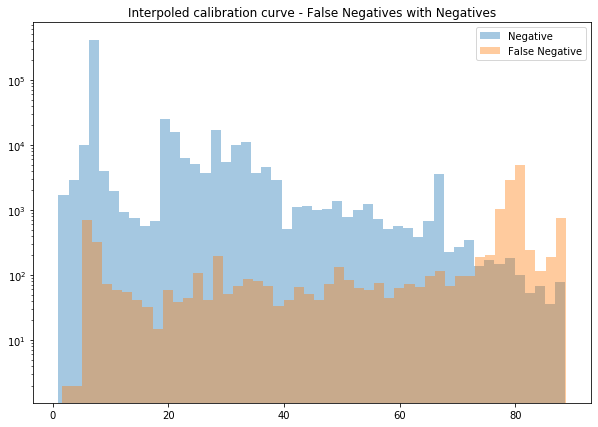

In [661]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set( yscale="log")
plt.title("Interpoled calibration curve - False Negatives with Negatives")
sns.distplot(df_trans[(df_trans.isFraud == False) & (df_trans.fraud == False)  & (df_trans.score > 0)].score.values, kde=False, ax=ax, label="Negative")
sns.distplot(df_trans[(df_trans.isFraud == True) & (df_trans.fraud == False)  & (df_trans.score > 0)].score.values,  kde=False, ax=ax, label="False Negative")
plt.legend(loc='best')
plt.show()

In [674]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(df_trans.isFraud, df_trans.score)

In [666]:
roc_auc = roc_auc_score(df_trans.isFraud, df_trans.score)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9635828450052801


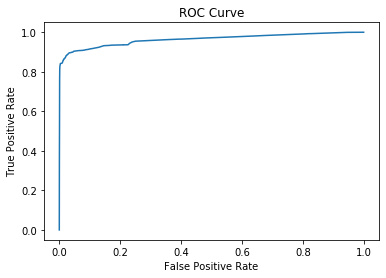

In [667]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Nexts steps: 
                * Include another dataset variables
                * Improve tradeoff with Recall vs Precision
                

In [675]:
average_precision = average_precision_score(df_trans.isFraud, df_trans.score)

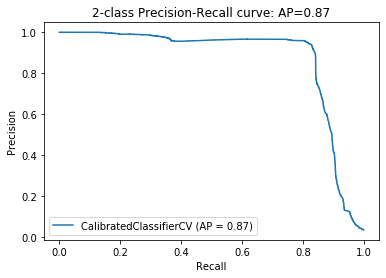

In [677]:
disp = plot_precision_recall_curve(clf_sigmoid, quantil.transform(df_trans[selected_vars2].fillna(0)), df_trans.isFraud)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

In [678]:
df_trans.to_csv("data_predicted.csv")